## Dynamic Mode Decomposition to Characterize Chemical Reactor Mixing

Proper orthogonal decomposition, also known as principal component analysis (PCA), is a popular technique in the field of fluid dynamics. POD/PCA is based on the singular value decomposition (SVD) of a data matrix. In a fluid dynamic system, the left singular vectors of the SVD are related to spatial components of the data, and the right singular vectors correspond to time correlations. Thus, it can be used to pull out low rank structure in complex fluid flows.

Dynamic mode decomposition (DMD) is a dimensionality reduction technique that can pull out spatiotemporal structures in time series data. This algorithm is particularly powerful in modeling fluid flows with non-linear dynamics. 

The key advantages to both POD/PCA and DMD are that data is used to characterize the dynamics of a system rather than complex partial differential equations. The low rank structures that result from these algorithms have interpretable results, which can be used to characterize complex fluid flows and mixing. 

The purpose of this notebook is to compare these two techniques in a simulated "reactor" consisting of a beaker filled with water being stired with an agitator. 

## DMD Algorithm

The first step of DMD is to break up a matrix $X$ into two matrices $X_1$ and $X_2$. We consider the columns of $X$ to be different snapshots of data in time. If we define $X$ to have $k$ columns/time steps, then $X_1$ represents time steps $1$ to $k - 1$. $X_2$ then represents time steps $2$ to $k$. We can then formulate the following equation:

$$X_2 = AX_1$$

The matrix $A$ can be viewed as a "best fit" linear operator that advances the matrix $X_1$ one step forward in time. The solution to $A$ is

$$A = X_2 X_1^{\dagger}$$

Where $X_1^{\dagger}$ is the pseudo-inverse of $X_1$. The goal of DMD is to find the eigenvectors of $A$, which represent how the spatial structures of $X$ evolve with time. These eigenvectors can be reshaped, similar to that of an Eigenface, to capture the low rank spatiotemporal structures in the data. 

To find the eigenvectors of $A$, we take the SVD of of $X_1$ as 

$$X_1 = U \Sigma V^T$$

and plug into the equation for $A$

$$A = X_2 (U \Sigma V^T)^{-1}$$

$$A = X_2 V \Sigma^{-1} U^T$$

It is more computationally efficient to project the matrix $A$ onto the dominant singular vectors of $X_1$ to compute a smaller matrix $\tilde{A}$. To further increase computationally efficiency, only the first $r$ features of $U$, $\Sigma$ and $V^T$ can be taken as a lower rank approximation of the SVD of $X_1$. 

$$\tilde{A} = U^T A U$$

Plugging back into $A$

$$\tilde{A} = U^T X_2 V \Sigma^{-1} U^T U$$

and since $U^TU = I$ we can obtain

$$\tilde{A} = U^T X_2 V \Sigma^{-1} $$

Next, we compute the eigenvectors of $\tilde{A}$ as

$$\tilde{A} W = W \lambda$$

The ultimate goal is to find the eigenvectors of $A$. The following formula uses the eigenvectors $W$ from $\tilde{A}$ to compute the eigenvectors of $A$:

$$\Phi = X_2 V \Sigma^{-1} W$$

## DMD Code

The following class computes the DMD of a matrix with a specified reduced rank. It assumes the data is in format of rows as observations and columns as features. It also contains methods to compute PCA by calculating the leading eigenvectors of the input matrix, as well as methods to plot the projected matricies after computing DMD and PCA. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class DMD:
    
    def __init__(self, data, rank):
        
        self.data = data
        self.rank = rank
        self.X1 = data.T[:, :-1]
        self.X2 = data.T[:, 1:]
        self.u, self.sigma, self.vt = np.linalg.svd(self.X1)
        self.u_pca, _, _ = np.linalg.svd(self.data.T)
        self.u = self.u[:, :self.rank]
        self.sigma = self.sigma[:self.rank]
        self.vt = self.vt[:self.rank, :]
        
    def compute_DMD(self):
        
        A_tilde = self.u.T @ self.X2 @ self.vt.T @ np.linalg.inv(np.diag(self.sigma))
        
        evals, evecs = np.linalg.eig(A_tilde)
        self.phi = self.X2 @ self.vt.T @ np.linalg.inv(np.diag(self.sigma))\
            @ evecs.real
    
    def plot_DMD(self, pic_shape, plot_rows, plot_cols):

        fig, ax = plt.subplots(plot_rows, plot_cols, figsize = (15, 10))
        ax = ax.ravel()
        for i in range(plot_rows * plot_cols):
            ax[i].imshow(self.phi[:, i].reshape(pic_shape), cmap = 'seismic')
            ax[i].set_title('DMD Mode ' + str(i + 1) )
        fig.suptitle('Top {} Modes of DMD'.format(plot_rows * plot_cols),\
                     fontsize = '16') 
        plt.tight_layout()
    
    def plot_pca(self, pic_shape, plot_rows, plot_cols):
        
        
        fig, ax = plt.subplots(plot_rows, plot_cols, figsize = (15, 10))
        ax = ax.ravel()
        for i in range(plot_rows * plot_cols):
            ax[i].imshow(self.u_pca[:, i].reshape(pic_shape), cmap = 'seismic')
            ax[i].set_title('PCA ' + str(i + 1) )
        fig.suptitle('Top {} Principal Components'.format(plot_rows *  plot_cols),\
                     fontsize = '16') 
        plt.tight_layout()

## Data

The data will be pictures of individual frames in the video, and each frame will represent a single observation in time. The resulting data matrix will be vectorized frames with dememsions ($m$ x $n$ pixels) by ($k$ total frames). The beaker mixing video was originally a video consisting of 169 total frames containing images with dimensions 1920 x 1080. To conserve memory, these images were downsampled to 100 x 100. This results in a final data matrix with dimensions 10000 x 169 to be fed into the PCA and DMD algorithms. 

The following code processes the videos into a series of images to be fed into the DMD algorithm. The original video can be seen in the attached file. 

In [2]:
import cv2

class video2images:
    
    def __init__(self, file, size):
        
        self.file = file
        self.size = size
        self.cap = cv2.VideoCapture(self.file)
        self.cap.set(cv2.CAP_PROP_POS_AVI_RATIO, 0)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    def get_images(self):
        i = 0
        ret = True
        a = np.zeros((self.frame_count, self.size ** 2))
        while (i < self.frame_count):
            ret, f = self.cap.read()
            f = cv2.resize(f, (self.size, self.size))
            gray = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY).reshape((self.size ** 2))
            a[i, :] = gray
            i += 1
        self.cap.release()
        self.images = a

The following code with run DMD and PCA with a reduced rank of 10 and plot each of these 10 modes

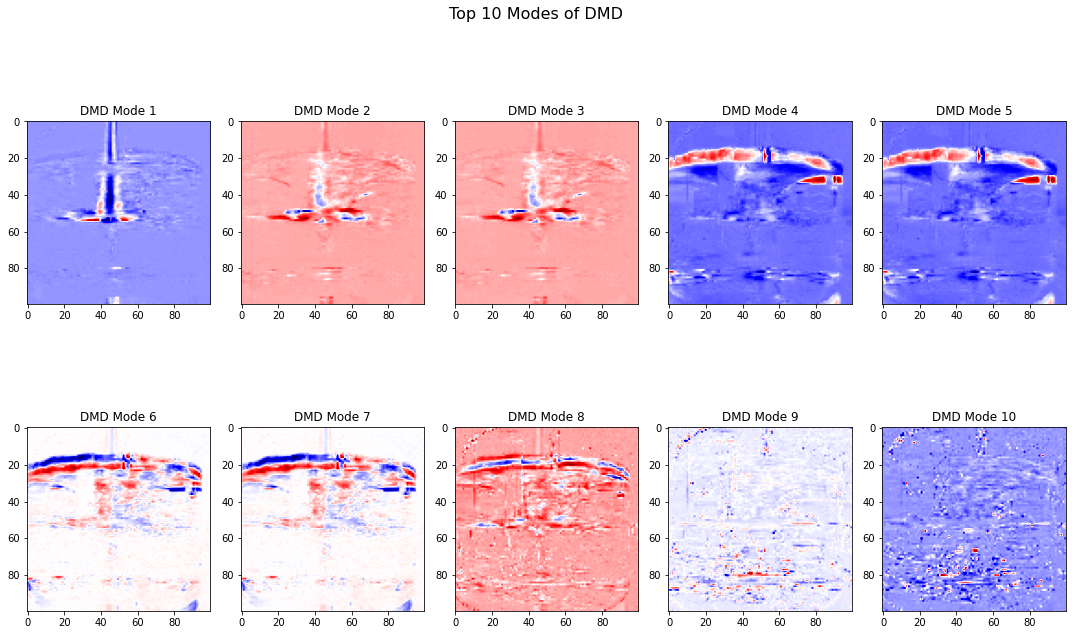

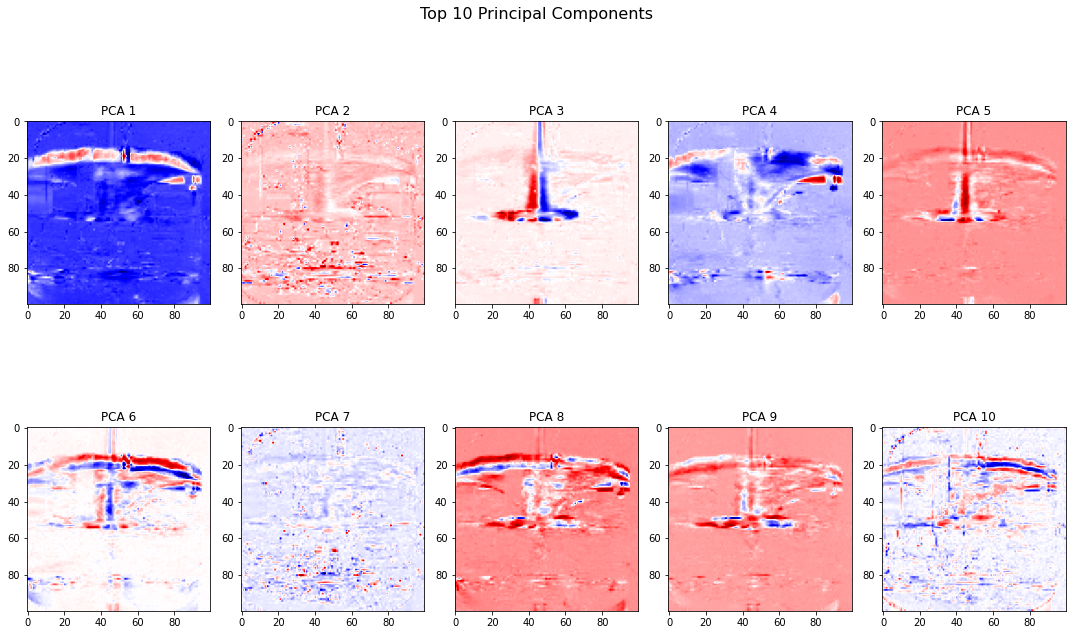

In [3]:
v2i = video2images('beaker_sim.mov', size = 100)
v2i.get_images()
data = v2i.images
data = data - np.mean(data, axis = 0)
dmd = DMD(data, 10)
dmd.compute_DMD()

%matplotlib inline
dmd.plot_DMD((100, 100), 2, 5)
dmd.plot_pca((100, 100), 2, 5)

## Results

DMD immediately captures the mixing characteristics in the beaker! The first mode shows the mixing primarily occurring at the agitator. The majority of the dynamics of the system are occurring at this point since it is spinning extremely fast. The next several modes show how the mixing "moves up" in an inverted cone like region of the agitator. This shows how powerful DMD can be for not only capturing spacial features, but temporal features as well. This serves as a good proof of concept that this technique is useful to model chemical reactor mixing. 

For PCA, the first principal component does a good job of capturing the swirling action of the water mixing. Interestingly, the second principal component looks mostly like noise. However, I believe this is due to the fact that the mixing is "blurring" a lot of the background and the images in general. The PC's 3 - 6 do an excellent job of capturing the mixing characteristics! The third principal component captures the agitator mixing the water, and the subsequent PC's do a good job of capturing how the mixer is dispersing the fluid.

Overall these methods provide equation free and computationally efficient methods to explore the complex dyanmics in reactor mixing. DMD is especially powerful in capturing non-linear spatiotemporal features in reactor mixing. 